# Feature extraction with LBP

In [2]:
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
!unzip -q -n 'tiny-imagenet-200.zip'

--2019-05-02 13:05:40--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.5MB/s    in 18s     

2019-05-02 13:05:58 (13.5 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Normalize validation scaffolding

In [0]:
import os, shutil
import pandas as pd


def change_validation_scaffolding(base_route, definition_file, separator):
  validation_data = _load_validation_data(definition_file, separator)
  
  for row in validation_data.iterrows():
    file = row[1]["file"]
    label = row[1]["label"]
    
    label_folder = os.path.join(base_route, label)
    
    if not os.path.exists(label_folder):
      os.mkdir(label_folder)
    
    shutil.move(os.path.join(base_route, file), os.path.join(label_folder, file))


def _load_validation_data(definition_file, separator):
  validation_data = pd.read_csv(
    definition_file,
    sep=separator,
    header=None
  )
  
  validation_data.columns = ["file", "label", "0", "1", "2", "3"]
  
  return validation_data

In [0]:
change_validation_scaffolding("tiny-imagenet-200/val/images", "tiny-imagenet-200/val/val_annotations.txt", '\t')

## LBP extractor definition

In [0]:
import numpy as np
from skimage import feature


class LBPExtractor:
  
  def __init__(self, points, radius):
    self.points = points
    self.radius = radius
  
  def get_image_hist(self, image, eps=1e-7):
    lbp = feature.local_binary_pattern(
        image, 
        self.points, 
        self.radius, 
        method="uniform"
    )
    
    hist, _ = np.histogram(
        lbp,
        bins=np.arange(0, self.points + 3),
        range=(0, self.points + 2)
    )
    
    hist = hist.astype("float")
    hist /= hist.sum() + eps
    
    return hist

In [0]:
import cv2

def get_hist_from_img_route(image_route, lbp_extractor):
  image = cv2.imread(image_route)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return lbp_extractor.get_image_hist(gray_image)

## One image example

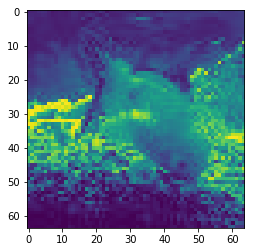

In [45]:
import matplotlib.pyplot as plt

image_route = 'tiny-imagenet-200/train/n01443537/images/n01443537_1.JPEG'
img = cv2.imread(image_route)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image)

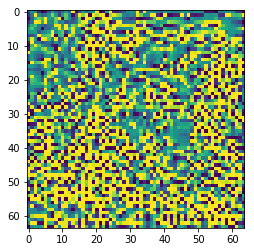

In [72]:
radius = 1
points = 32

lbp_image = feature.local_binary_pattern(gray_image, P=points, R=radius, method="uniform")
plt.imshow(lbp_image)

In [74]:
hist, _ = np.histogram(lbp_image,bins=np.arange(0, 27), range=(0, points + 2))

hist = hist.astype("float")
#hist /= hist.sum() + 1e-7

hist

array([398., 114.,  55.,  70.,  76.,  58.,  78.,  81.,  56.,  55.,  67.,
        72.,  85.,  98., 100., 113., 123., 132., 113.,  94.,  65.,  78.,
        77.,  69.,  58., 139.])

In [0]:

class ImageGrid:
  def __init__(self, width, height, grid_x, grid_y):
    self.width = width
    self.height = height
    self.height_step = self.height//grid_y
    self.width_step = self.width//grid_x

  def get_grid(self, image):
    grid = []

    for y in range(0, self.height, self.height_step):
      for x in range(0, self.width, self.width_step):
        y1 = y + self.height_step
        x1 = x + self.width_step

        grid.append(im[y:y1, x:x1])

    return grid

In [95]:
img_grid = ImageGrid(width=64, height=64, grid_x=4, grid_y=4)
img_grid.get_grid(lbp_image)

[array([[ 0.,  0.,  0.,  0.,  0.,  2.,  9., 18., 11.,  7., 12., 17., 12.,
         33.,  1.,  7.],
        [ 0., 13., 33.,  0., 11., 12., 17., 27., 18.,  6., 18., 25., 15.,
          1., 12., 33.],
        [ 0., 10., 21.,  0., 23., 33., 19., 16., 26., 33.,  0., 24., 17.,
          7., 11., 26.],
        [ 0.,  0.,  0.,  0., 21., 33., 16., 15., 25., 14., 17.,  8., 10.,
         10., 13., 25.],
        [10., 21., 23., 14., 11.,  9., 13., 14., 32., 32., 17., 33., 15.,
         26., 23., 33.],
        [18., 24., 17., 14.,  0., 11., 11., 17., 19., 32., 19., 33., 23.,
         32., 19., 15.],
        [17., 18., 19.,  9., 14., 16., 19., 33., 16., 21., 25.,  6., 16.,
         32., 16., 17.],
        [ 7.,  8., 12., 33., 23., 23., 25., 33.,  0., 22., 23.,  0., 33.,
         26., 13.,  7.],
        [17., 32., 18.,  0., 33., 32., 24., 13., 32.,  8., 13., 32., 13.,
          8., 27., 21.],
        [ 2., 33., 14., 14.,  7., 11., 12.,  8., 17., 11., 21., 28., 12.,
         16., 26., 33.],
        [ 

## Features extraction

In [0]:
import math, sys

def update_counter(counter):
  counter = counter + 1

  if (counter % 10) == 0:
    sys.stdout.write("{}%".format(math.floor(counter/total_labels * 100)))
  else:
    sys.stdout.write('.')
    
  return counter

In [15]:
import os

lbp_extractor = LBPExtractor(points=24, radius=8)
train_images_route = "tiny-imagenet-200/val/images"

train = []
labels = []

counter = 0
total_labels = 200

for folder_name in os.listdir(train_images_route):
  folder_route = os.path.join(train_images_route, folder_name) # , "/images"
  counter = update_counter(counter)

  for image_name in os.listdir(folder_route):
    image_route = os.path.join(folder_route, image_name)
    
    train.append(get_hist_from_img_route(image_route, lbp_extractor))
    labels.append(folder_name)

.........5%.........10%.........15%.........20%.........25%.........30%.........35%.........40%.........45%.........50%.........55%.........60%.........65%.........70%.........75%.........80%.........85%.........90%.........95%.........100%

## Save featue to CSV

In [0]:
df = pd.DataFrame(train).assign(label=labels)

df.to_csv('lbp_val.csv')

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,0.072266,0.051270,0.023437,0.018311,0.004639,0.008789,0.011230,0.010986,0.011963,0.007812,...,0.008789,0.007324,0.013916,0.006836,0.010498,0.011230,0.019775,0.025879,0.607178,n02410509
1,0.066895,0.051758,0.011230,0.005371,0.003174,0.000732,0.002441,0.002686,0.004150,0.004639,...,0.009766,0.004150,0.006592,0.006836,0.007568,0.008057,0.020752,0.025635,0.712891,n02410509
2,0.064209,0.057373,0.010986,0.003418,0.002930,0.002930,0.004883,0.005859,0.005371,0.012695,...,0.009766,0.004639,0.006836,0.005127,0.007812,0.007568,0.017822,0.020508,0.639648,n02410509
3,0.051514,0.052734,0.015137,0.005859,0.003906,0.005127,0.006104,0.007324,0.008545,0.011719,...,0.008057,0.003418,0.002686,0.001953,0.003418,0.009521,0.025146,0.020508,0.686279,n02410509
4,0.062256,0.037598,0.018555,0.012695,0.011719,0.013428,0.016113,0.018555,0.016846,0.022217,...,0.006104,0.007568,0.007080,0.007568,0.004639,0.009766,0.018555,0.028564,0.564209,n02410509


In [0]:
!cp 'lbp_val.csv' 'drive/My Drive/Colab Notebooks/TFM-image-feature-selection/datasets/lbp_val.csv'

## Data exploration

In [0]:
import pandas as pd

pd.DataFrame(train).describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.053729,0.044994,0.018436,0.012932,0.010371,0.009586,0.009381,0.011624,0.011979,0.012944,...,0.003858,0.007257,0.003263,0.005835,0.003377,0.005719,0.007338,0.021486,0.030551,0.634631
std,0.013386,0.010562,0.006662,0.006550,0.006391,0.006494,0.006745,0.008760,0.009502,0.011329,...,0.003275,0.004663,0.002453,0.003106,0.002408,0.003290,0.003092,0.005865,0.026470,0.084986
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023926
25%,0.045654,0.038818,0.013916,0.008301,0.005859,0.004883,0.004639,0.005371,0.005371,0.005371,...,0.001709,0.004883,0.001709,0.003906,0.001709,0.003662,0.005127,0.017822,0.022705,0.596924
50%,0.055176,0.045898,0.017822,0.011963,0.009033,0.008057,0.007812,0.009521,0.009521,0.009766,...,0.002930,0.006348,0.002686,0.005371,0.002930,0.005127,0.006836,0.021729,0.027832,0.655029
75%,0.063232,0.052246,0.022217,0.016357,0.013428,0.012695,0.012451,0.015381,0.015625,0.016846,...,0.005127,0.008545,0.004150,0.007080,0.004395,0.007080,0.009033,0.025391,0.032959,0.694580
max,0.158936,0.108154,0.082031,0.083496,0.103760,0.079346,0.070312,0.099365,0.120850,0.154053,...,0.043213,0.118408,0.044434,0.064453,0.040283,0.069580,0.037842,0.088623,0.928467,0.825684


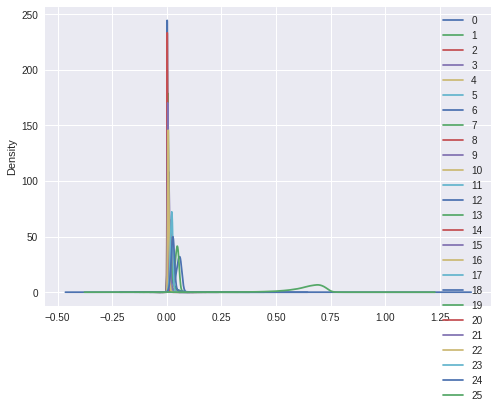

In [0]:
pd.DataFrame(train).plot.kde()

In [0]:
from sklearn import preprocessing

train = preprocessing.scale(train, axis=0)

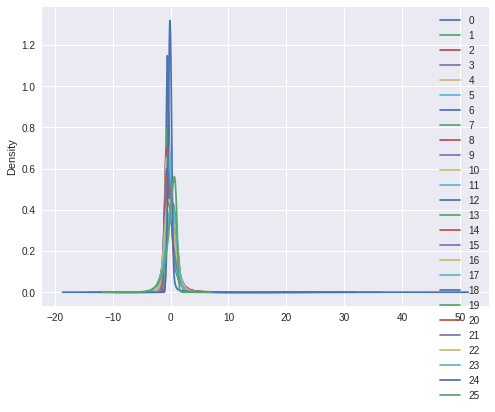

In [0]:
pd.DataFrame(train).plot.kde()

## Training a classification model

In [0]:
import pandas as pd

train = pd.read_csv('drive/My Drive/Colab Notebooks/TFM-image-feature-selection/datasets/lbp.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/TFM-image-feature-selection/datasets/lbp_val.csv')

y = train[['label']].values.ravel()
X = train.drop(['label', 'Unnamed: 0'], axis=1)

y_test = test[['label']].values.ravel()
X_test = test.drop(['label', 'Unnamed: 0'], axis=1)

### Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
model = gnb.fit(X, y)

y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.005

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=3000, max_depth=5, random_state=0).fit(X, y)

y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.005

### SVC

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

model = SVC()

scores = cross_val_score(model, train, labels, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [0]:
scores

array([0.04575, 0.0446 , 0.04515, 0.0455 , 0.04065])

In [0]:
import pickle

pickle.dumps(model)

b'\x80\x03csklearn.svm.classes\nSVC\nq\x00)\x81q\x01}q\x02(X\x17\x00\x00\x00decision_function_shapeq\x03X\x03\x00\x00\x00ovrq\x04X\x06\x00\x00\x00kernelq\x05X\x03\x00\x00\x00rbfq\x06X\x06\x00\x00\x00degreeq\x07K\x03X\x05\x00\x00\x00gammaq\x08X\x0f\x00\x00\x00auto_deprecatedq\tX\x05\x00\x00\x00coef0q\nG\x00\x00\x00\x00\x00\x00\x00\x00X\x03\x00\x00\x00tolq\x0bG?PbM\xd2\xf1\xa9\xfcX\x01\x00\x00\x00Cq\x0cG?\xf0\x00\x00\x00\x00\x00\x00X\x02\x00\x00\x00nuq\rG\x00\x00\x00\x00\x00\x00\x00\x00X\x07\x00\x00\x00epsilonq\x0eG\x00\x00\x00\x00\x00\x00\x00\x00X\t\x00\x00\x00shrinkingq\x0f\x88X\x0b\x00\x00\x00probabilityq\x10\x89X\n\x00\x00\x00cache_sizeq\x11K\xc8X\x0c\x00\x00\x00class_weightq\x12NX\x07\x00\x00\x00verboseq\x13\x89X\x08\x00\x00\x00max_iterq\x14J\xff\xff\xff\xffX\x0c\x00\x00\x00random_stateq\x15NX\x10\x00\x00\x00_sklearn_versionq\x16X\x06\x00\x00\x000.20.1q\x17ub.'

In [0]:
!cp 'lbp_svc' 'gdrive/My Drive/Colab Notebooks/TFM-image-feature-selection/lbp_svc'

## Debug

In [22]:
y_predict

array(['n02917067', 'n02917067', 'n02917067', ..., 'n02917067',
       'n02917067', 'n02917067'], dtype=object)

In [24]:
y_test

array(['n02410509', 'n02410509', 'n02410509', ..., 'n04251144',
       'n04251144', 'n04251144'], dtype=object)